In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.sql.functions import count, col, to_date, to_timestamp, isnan, when, mean, countDistinct

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
spark = SparkSession \
    .builder \
    .appName("Parking ticktes") \
    .getOrCreate()

Picked up _JAVA_OPTIONS: -Xmx6048m
Picked up _JAVA_OPTIONS: -Xmx6048m
23/07/23 10:20:53 WARN Utils: Your hostname, 5CG1165DMB resolves to a loopback address: 127.0.1.1; using 192.168.0.107 instead (on interface wlp0s20f3)
23/07/23 10:20:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/23 10:20:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/07/23 10:21:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [58]:
##Change data_path to just directory folder eg. data_path = "/home/heriG/Desktop/hackathon/NYCParkingTicket/"
#It will automatically pickup all the csv in that folder
data_path = "/home/heriG/Desktop/hackathon/NYCParkingTicket/Parking_Violations_Issued_-_Fiscal_Year_2017.csv"
parking = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(data_path).limit(20000)
parking.show(5)

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+--------------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+---------------------------------+-----------------+------------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Is

In [57]:
# Count the number of rows
num_rows = parking.count()
print(f"Number of rows: {num_rows}")

# Count the number of columns
num_columns = len(parking.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 10803028
Number of columns: 43


In [59]:
# Drop duplicates
parking=parking.dropDuplicates()
parking.count()

20000

In [51]:
# Check the data types of the variables
variable_types = parking.dtypes

# Print the variable name and its corresponding data type
for variable in variable_types:
    print(f"Variable: {variable[0]}, Data Type: {variable[1]}")

Variable: Summons Number, Data Type: bigint
Variable: Plate ID, Data Type: string
Variable: Registration State, Data Type: string
Variable: Plate Type, Data Type: string
Variable: Issue Date, Data Type: string
Variable: Violation Code, Data Type: int
Variable: Vehicle Body Type, Data Type: string
Variable: Vehicle Make, Data Type: string
Variable: Issuing Agency, Data Type: string
Variable: Street Code1, Data Type: int
Variable: Street Code2, Data Type: int
Variable: Street Code3, Data Type: int
Variable: Vehicle Expiration Date, Data Type: int
Variable: Violation Location, Data Type: int
Variable: Violation Precinct, Data Type: int
Variable: Issuer Precinct, Data Type: int
Variable: Issuer Code, Data Type: int
Variable: Issuer Command, Data Type: string
Variable: Issuer Squad, Data Type: string
Variable: Violation Time, Data Type: string
Variable: Time First Observed, Data Type: string
Variable: Violation County, Data Type: string
Variable: Violation In Front Of Or Opposite, Data Type

In [60]:
parking = parking.withColumn("Violation Precinct", col("Violation Precinct").cast("integer"))
parking = parking.withColumn('Issue Date', to_date(col("Issue Date"),"MM/dd/yyyy"))
parking = parking.withColumn('Violation Time', to_timestamp(col('Violation Time'), 'HH:mm'))

# Print the schema to verify the column types
parking.printSchema()
parking.show(10)

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Plate Type: string (nullable = true)
 |-- Issue Date: date (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: integer (nullable = true)
 |-- Street Code2: integer (nullable = true)
 |-- Street Code3: integer (nullable = true)
 |-- Vehicle Expiration Date: integer (nullable = true)
 |-- Violation Location: integer (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Issuer Code: integer (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Issuer Squad: string (nullable = true)
 |-- Violation Time: timestamp (nullable = true)
 |-- Time First Observed: string (nullable = true)
 |-- Violation Cou

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+--------------------+-------------------+-------------------+-----------+------------+--------------------+--------------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+---------------------------------+-----------------+------------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Is

In [61]:
# Basic statistics
parking.describe().show()

# Remove negative values (if applicable)
parking = parking.filter(col("Violation Code") >= 0)
parking = parking.filter(col("Street Code1") >= 0)
parking = parking.filter(col("Street Code2") >= 0)
parking = parking.filter(col("Street Code3") >= 0)
parking = parking.filter(col("Vehicle Expiration Date") >= 0)
parking = parking.filter(col("Violation Location") >= 0)
parking = parking.filter(col("Violation Precinct") >= 0)
parking = parking.filter(col("Issuer Precinct") >= 0)
parking = parking.filter(col("Issuer Code") >= 0)


+-------+--------------------+------------------+------------------+----------+------------------+------------------+------------+--------------+------------------+------------------+------------------+-----------------------+------------------+------------------+-----------------+-----------------+------------------+------------+-------------------+----------------+---------------------------------+------------------+-----------+-------------------+-------------------+------------------+------------------+--------------------+--------------------------+--------------------+------------------+-------------+---------------------+-----------------+------------+------------------+-------------------+---------------------+---------------------------------+-----------------+------------------------+
|summary|      Summons Number|          Plate ID|Registration State|Plate Type|    Violation Code| Vehicle Body Type|Vehicle Make|Issuing Agency|      Street Code1|      Street Code2|      Stree

In [62]:
# Drop columns with more than 80% null values
null_threshold = parking.count() * 0.8
parking = parking.drop(*[column for column in parking.columns if parking.filter(col(column).isNull()).count() > null_threshold])

In [50]:
# Count the number of columns
num_columns = len(parking.columns)
print(f"Number of columns: {num_columns}")

Number of columns: 34


In [43]:
##Issue Date string to month

#from pyspark.sql.functions import current_date, month, to_date
#parking_month = parking.select("Plate ID", "Summons Number", "Issue Date", month(to_date(col("Issue Date"),"MM/dd/yyyy")).alias("Issue Month"))
#parking_month.show(5)

+--------+--------------+----------+-----------+
|Plate ID|Summons Number|Issue Date|Issue Month|
+--------+--------------+----------+-----------+
| 66623ME|    8478629828|06/14/2017|          6|
| 37033JV|    7868300310|11/21/2016|         11|
|  X20DCM|    1413609545|08/03/2016|          8|
| 2513JMG|    1407740258|01/11/2017|          1|
| 13657MD|    8009901763|09/27/2016|          9|
+--------+--------------+----------+-----------+
only showing top 5 rows



In [42]:
#parking_month.count()

8730628

In [15]:
parking.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = false)
 |-- Plate Type: string (nullable = false)
 |-- Issue Date: date (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: integer (nullable = true)
 |-- Street Code2: integer (nullable = true)
 |-- Street Code3: integer (nullable = true)
 |-- Vehicle Expiration Date: integer (nullable = true)
 |-- Violation Location: integer (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Issuer Code: integer (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Issuer Squad: string (nullable = true)
 |-- Violation County: string (nullable = true)
 |-- Violation In Front Of Or Opposite: string (nullable = true)
 |-

In [63]:
# Calculate mean values for numerical columns
numeric_columns = ['Violation Code', 'Street Code1', 'Street Code2', 'Street Code3', 'Vehicle Expiration Date',
                   'Violation Location', 'Violation Precinct']
mean_values = parking.select(*(mean(col(column)).alias(column) for column in parking.columns if column in numeric_columns)).first().asDict()

# Impute missing values with mean values
for column in numeric_columns:
    if mean_values[column] is not None:
        parking = parking.fillna(mean_values[column], subset=[column])

In [64]:
# For categorical columns, impute missing values with mode
categorical_columns = ['Registration State', 'Plate Type']
for column in categorical_columns:
    mode_value = parking.groupBy(column).count().orderBy(col("count").desc()).first()
    if mode_value is not None:
        mode_value = mode_value[column]
        parking = parking.fillna(mode_value, subset=[column])

In [12]:
# Count missing values in each column
missing_counts = parking.select([count(when(col(c).isNull(), c)).alias(c) for c in parking.columns])
missing_counts.show()

+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+----------------+---------------------------------+------------+-----------+-------------------+-------------------+-----------+------------+--------------------------+--------------------+------------------+-------------+------------+--------------+-------------------+---------------------+
|Summons Number|Plate ID|Registration State|Plate Type|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Issuer Precinct|Issuer Code|Issuer Command|Issuer Squad|Violation County|Violation In Front Of Or Opposite|House Number|Street Name|Intersecting Street|Date First Observed|Law Section|Sub Divisio

23/07/19 00:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:02 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/19 00:29:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:10 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/19 00:29:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:29:21 WARN RowBasedKeyValueBatch: Calling spill() on

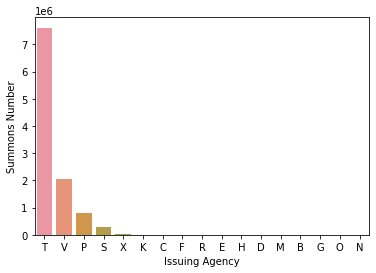

In [58]:
# Issuing agency vs Summons dataframe
ia_plot = parking.groupby(['Issuing Agency']).count().withColumnRenamed('count', 'Summons Number').sort(col('Summons Number').desc()).toPandas()

# Drop rows with missing values
ia_plot = ia_plot.dropna()

# Bar plot
# Check if there are valid values for plotting
if not ia_plot.empty:
    # Bar plot
    sns.barplot(x='Issuing Agency', y='Summons Number', data=ia_plot)
    plt.show()
else:
    print("No valid data available for plotting.")

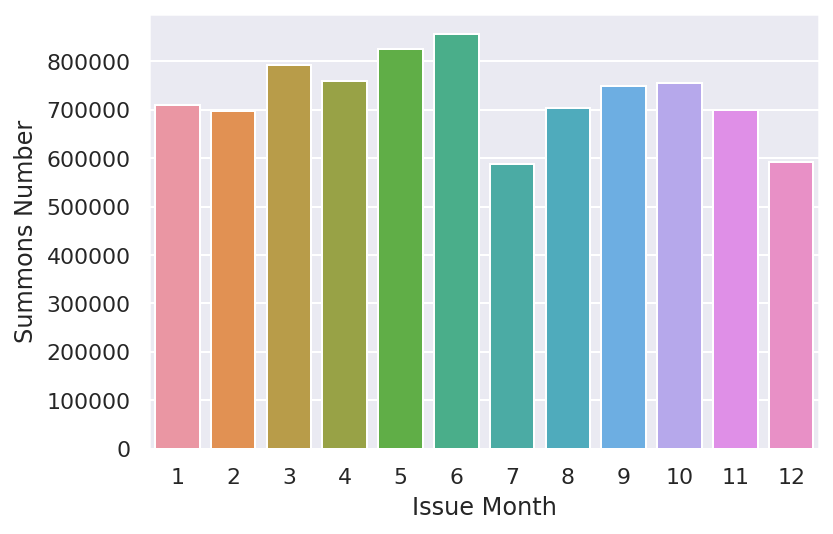

In [44]:
# Issuing agency vs Summons dataframe
month_plot = parking.groupby(month(to_date(col("Issue Date"),"MM/dd/yyyy")).alias("Issue Month")).count().withColumnRenamed('count', 'Summons Number').sort(col('Summons Number').desc()).toPandas()

# Drop rows with missing values
month_plot = month_plot.dropna()

# Bar plot
# Check if there are valid values for plotting
if not month_plot.empty:
    # Bar plot
    sns.barplot(x='Issue Month', y='Summons Issued', data=month_plot)
    plt.show()
else:
    print("No valid data available for plotting.")

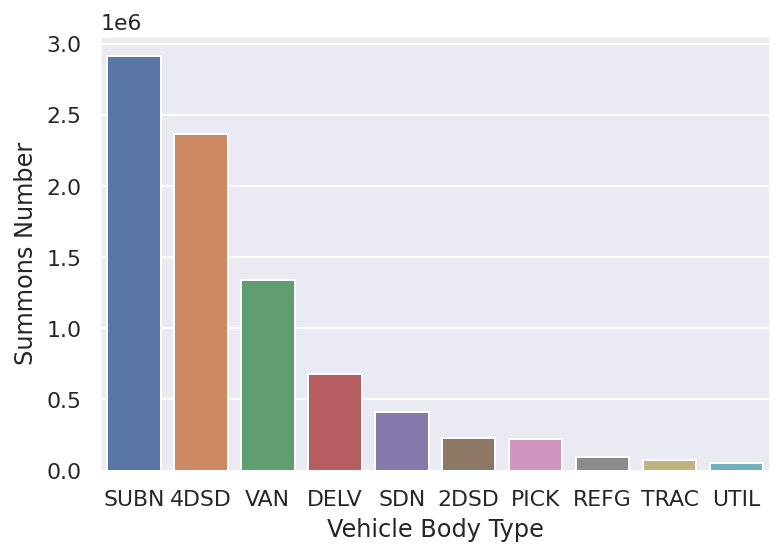

In [51]:
# Issuing agency vs Summons dataframe
vehicle_body_plot = parking.groupby(["Vehicle Body Type"]).count().withColumnRenamed('count', 'Summons Number').sort(col('Summons Number').desc()).limit(10).toPandas()

# Drop rows with missing values
vehicle_body_plot = vehicle_body_plot.dropna()

# Bar plot
# Check if there are valid values for plotting
if not vehicle_body_plot.empty:
    # Bar plot
    sns.barplot(x='Vehicle Body Type', y='Summons Number', data=vehicle_body_plot)
    plt.show()
else:
    print("No valid data available for plotting.")

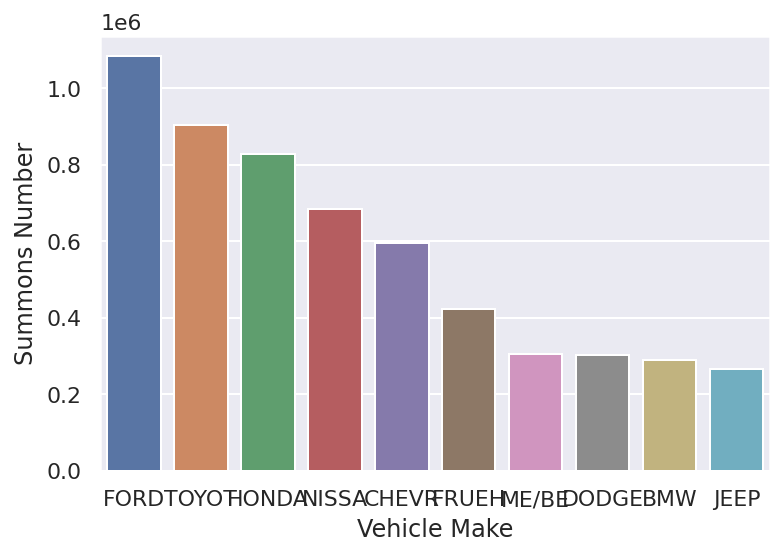

In [53]:
# Issuing agency vs Summons dataframe
vehicle_make_plot = parking.groupby(["Vehicle Make"]).count().withColumnRenamed('count', 'Summons Number').sort(col('Summons Number').desc()).limit(10).toPandas()

# Drop rows with missing values
vehicle_make_plot = vehicle_make_plot.dropna()

# Bar plot
# Check if there are valid values for plottingvehicle_body_plot
if not vehicle_make_plot.empty:
    # Bar plot
    sns.barplot(x='Vehicle Make', y='Summons Number', data=vehicle_make_plot)
    plt.show()
else:
    print("No valid data available for plotting.")

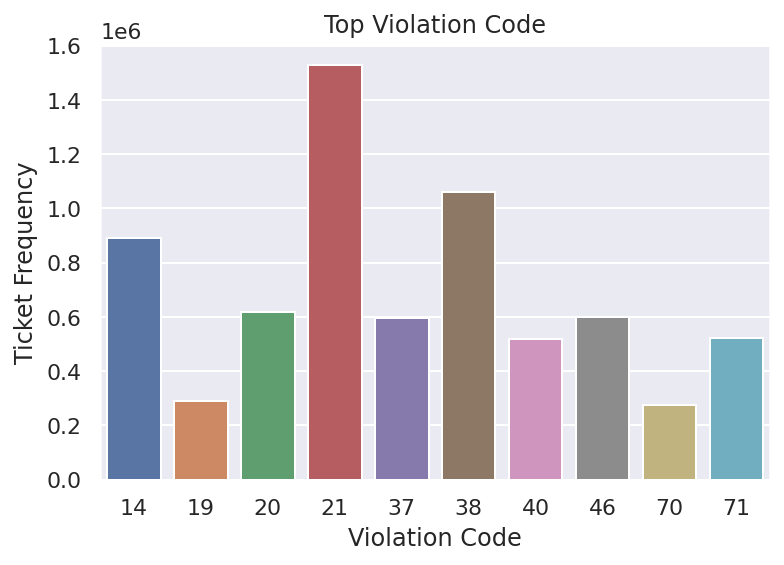

In [55]:
# Issuing agency vs Summons dataframe
vehicle_make_plot = parking.groupby(["Violation Code"]).count().withColumnRenamed('count', 'Summons Number').sort(col('Summons Number').desc()).limit(10).toPandas()

# Drop rows with missing values
vehicle_make_plot = vehicle_make_plot.dropna()

# Bar plot
# Check if there are valid values for plottingvehicle_body_plot
if not vehicle_make_plot.empty:
    # Bar plot
    sns.barplot(x='Violation Code', y='Summons Number', data=vehicle_make_plot)
    plt.title("Top 10 Violation Code")
    plt.xlabel('Violation Code')
    plt.ylabel('Ticket Frequency')
    plt.show()
else:
    print("No valid data available for plotting.")

In [49]:
df2=parking.select(countDistinct("Vehicle Body Type"))
df2.show()


+---------------------------------+
|count(DISTINCT Vehicle Body Type)|
+---------------------------------+
|                             1634|
+---------------------------------+



In [62]:
from pyspark.sql.functions import F 
# Vehicle registration state (Top 10) vs Summons
top_10_states = parking.groupBy('Plate Type').count().orderBy(F.desc('count')).limit(10)
top_10_states.show()

23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/19 00:44:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:41 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+-------+
|Plate Type|  count|
+----------+-------+
|       PAS|7993499|
|       COM|1839534|
|       OMT| 450185|
|       OMS| 108568|
|       SRF|  88713|
|       IRP|  56828|
|       999|  54663|
|       TRC|  27236|
|       MOT|  26384|
|       OMR|  20886|
+----------+-------+



In [60]:
# Vehicle registration state (Top 10) vs Summons
top_10_states = parking.groupBy('Registration State').count().orderBy(F.desc('count')).limit(10)
top_10_states.show()

23/07/19 00:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:51 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/19 00:35:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:35:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:00 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/19 00:36:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:36:11 WARN RowBasedKeyValueBatch: Calling spill() on

+------------------+-------+
|Registration State|  count|
+------------------+-------+
|                NY|8481061|
|                NJ| 925965|
|                PA| 285419|
|                FL| 144556|
|                CT| 141088|
|                MA|  85547|
|                IN|  80749|
|                VA|  72626|
|                MD|  61800|
|                NC|  55806|
+------------------+-------+



In [62]:
# Vehicle registration state (Top 10) vs Summons
top_10_states = parking.groupBy('Plate Type').count().orderBy(F.desc('count')).limit(10)
top_10_states.show()

23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:19 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/19 00:44:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:29 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/19 00:44:41 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+-------+
|Plate Type|  count|
+----------+-------+
|       PAS|7993499|
|       COM|1839534|
|       OMT| 450185|
|       OMS| 108568|
|       SRF|  88713|
|       IRP|  56828|
|       999|  54663|
|       TRC|  27236|
|       MOT|  26384|
|       OMR|  20886|
+----------+-------+



In [26]:
# Vehicle registration state (Top 10) vs Summons
location = parking.groupBy('Violation Location').count().orderBy(F.desc('count')).limit(10)
location.show()

23/07/20 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:40:58 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/20 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:41:09 WARN RowBasedKeyValueBatch: Calling spill() on

23/07/20 14:41:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/07/20 14:41:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+------------------+------+
|Violation Location| count|
+------------------+------+
|                19|535671|
|                14|352450|
|                 1|331810|
|                18|306920|
|               114|296514|
|                13|246595|
|               109|218141|
|                17|193024|
|                70|192831|
|               115|174332|
+------------------+------+



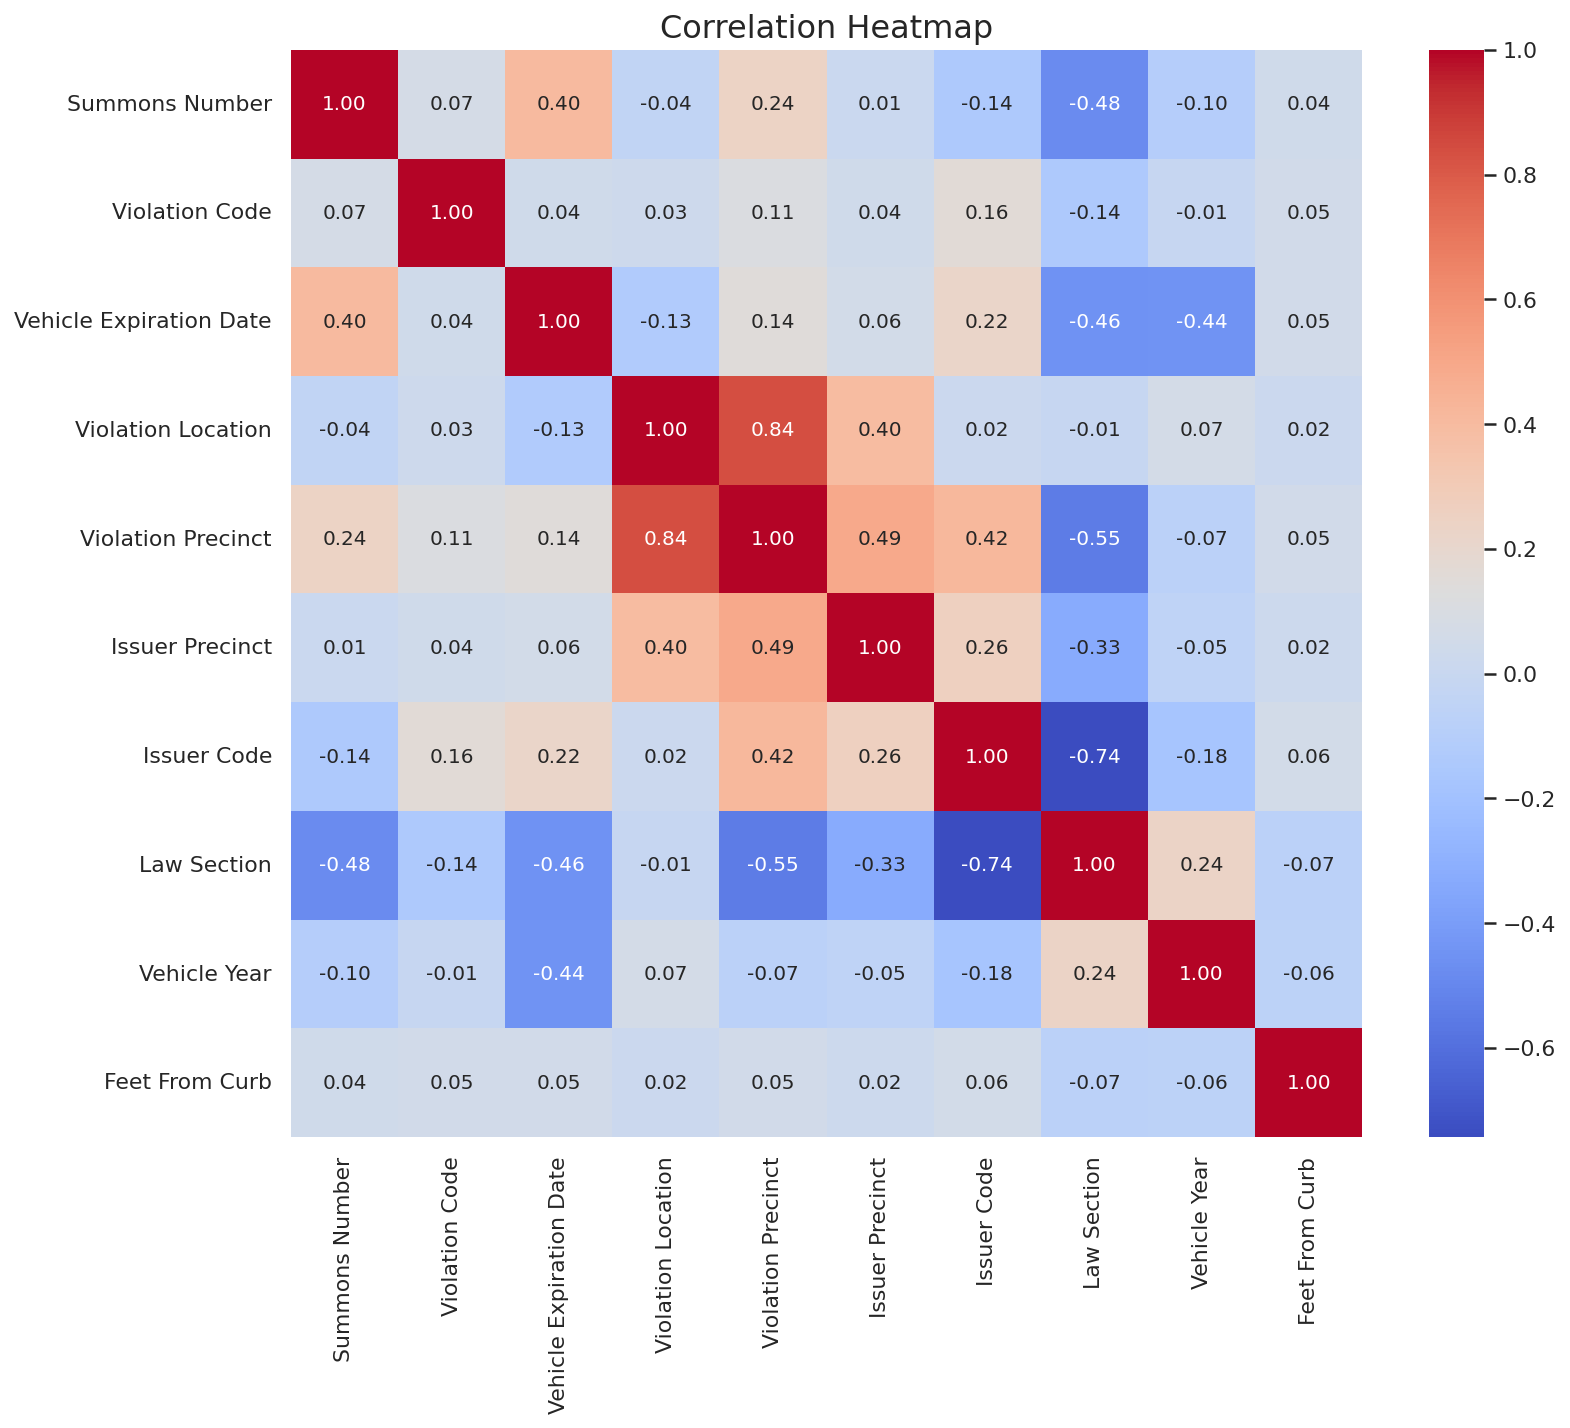

In [13]:
# Select relevant columns for correlation (excluding non-numeric columns like Plate ID, Street Name, etc.)
selected_columns = ['Summons Number', 'Registration State', 'Plate Type', 'Violation Code', 'Vehicle Body Type',
                    'Vehicle Make', 'Issuing Agency', 'Vehicle Expiration Date', 'Violation Location',
                    'Violation Precinct', 'Issuer Precinct', 'Issuer Code', 'Law Section', 'Vehicle Year',
                    'Feet From Curb']

selected_df = parking.select(selected_columns)

# Convert PySpark DataFrame to Pandas DataFrame for correlation calculation
pandas_df = selected_df.toPandas()

# Calculate the correlation matrix
correlation_matrix = pandas_df.corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()


In [65]:
# Remove trailing spaces from column names
categorized_df = parking
for column in parking.columns:
    new_col_name = column.strip()
    categorized_df = categorized_df.withColumnRenamed(column, new_col_name)

# Update the list of categorical columns
categorical_cols = ['Plate ID', 'Registration State', 'Plate Type', 'Vehicle Body Type', 'Vehicle Make',
                    'Issuing Agency', 'Issuer Command', 'Issuer Squad', 'Violation County',
                    'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
                    'Sub Division', 'Days Parking In Effect', 'From Hours In Effect', 'To Hours In Effect',
                    'Vehicle Color', 'Violation Post Code', 'Violation Description']

# Apply StringIndexer on categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip")
            for col in categorical_cols]

# Apply OneHotEncoder on indexed categorical columns
encoders = [OneHotEncoder(inputCols=[col + "_index"], outputCols=[col + "_encoded"])
            for col in categorical_cols]

# Apply StringIndexer to "Violation Location" column
violation_location_indexer = StringIndexer(inputCol='Violation Location', outputCol='ViolationLocation_encoded', handleInvalid='skip')

# Create a pipeline for transformation
pipeline = Pipeline(stages=indexers + encoders + [violation_location_indexer])
categorized_df = pipeline.fit(categorized_df).transform(categorized_df)

# Select the encoded and numerical columns
selected_columns = ['Registration State_encoded', 'Plate Type_encoded', 'Violation Code', 'Vehicle Body Type_encoded',
                    'Vehicle Make_encoded', 'Issuing Agency_encoded', 'Street Code1', 'Street Code2', 'Street Code3',  'Street Name_encoded',
                    'Vehicle Expiration Date', 'ViolationLocation_encoded', 'Violation Precinct', 'Issuer Precinct',
                    'Issuer Code', 'Law Section', 'Vehicle Year', 'Feet From Curb', 'Days Parking In Effect_encoded',
                    'Issuer Command_encoded', 'Violation County_encoded', 'Vehicle Color_encoded', 'Violation Post Code_encoded', 'Violation Description_encoded' ]

categorized_df = categorized_df.select(selected_columns)

# Display the resulting DataFrame
categorized_df.show()


23/07/23 14:16:52 WARN DAGScheduler: Broadcasting large task binary with size 1266.5 KiB


+--------------------------+------------------+--------------+-------------------------+--------------------+----------------------+------------+------------+------------+-------------------+-----------------------+-------------------------+------------------+---------------+-----------+-----------+------------+--------------+------------------------------+----------------------+------------------------+---------------------+---------------------------+-----------------------------+
|Registration State_encoded|Plate Type_encoded|Violation Code|Vehicle Body Type_encoded|Vehicle Make_encoded|Issuing Agency_encoded|Street Code1|Street Code2|Street Code3|Street Name_encoded|Vehicle Expiration Date|ViolationLocation_encoded|Violation Precinct|Issuer Precinct|Issuer Code|Law Section|Vehicle Year|Feet From Curb|Days Parking In Effect_encoded|Issuer Command_encoded|Violation County_encoded|Vehicle Color_encoded|Violation Post Code_encoded|Violation Description_encoded|
+-----------------------

In [66]:
# Split the data into train and test sets
train_ratio = 0.8  # Set the ratio for the train set
test_ratio = 1 - train_ratio

# Perform the split
train_data, test_data = categorized_df.randomSplit([train_ratio, test_ratio], seed=42)

# Print the number of records in each set
print("Train set count:", train_data.count())
print("Test set count:", test_data.count())


23/07/23 14:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1304.9 KiB


Train set count: 6361


23/07/23 14:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1304.9 KiB


Test set count: 1503


In [67]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

# Define the features and target columns
features = ['Registration State_encoded', 'Plate Type_encoded', 'Violation Code', 'Vehicle Body Type_encoded',
            'Vehicle Make_encoded', 'Issuing Agency_encoded', 'Street Code1', 'Street Code2', 'Street Code3', 'Street Name_encoded',
            'Vehicle Expiration Date', 'Violation Precinct', 'Issuer Precinct', 'Issuer Code',
            'Law Section', 'Vehicle Year', 'Feet From Curb', 'Days Parking In Effect_encoded',
            'Issuer Command_encoded', 'Violation County_encoded', 'Vehicle Color_encoded',
            'Violation Post Code_encoded', 'Violation Description_encoded']

target = "ViolationLocation_encoded"

# Create a vector assembler to combine the features into a feature vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Transform the training and test data using the vector assembler
training_data = assembler.transform(train_data).drop("features")
testing_data = assembler.transform(test_data).drop("features")

rf_classifier = RandomForestClassifier(labelCol="ViolationLocation_encoded", featuresCol="features")

pipeline = Pipeline(stages=[assembler, rf_classifier])
model = pipeline.fit(training_data)

predictions = model.transform(testing_data)

#Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="ViolationLocation_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the root mean squared error (RMSE)
print("Root Mean Squared Error (RMSE):", rmse)


23/07/23 14:17:28 WARN DAGScheduler: Broadcasting large task binary with size 1742.4 KiB
23/07/23 14:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1742.5 KiB
23/07/23 14:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1746.0 KiB
23/07/23 14:17:30 WARN DAGScheduler: Broadcasting large task binary with size 1936.1 KiB
23/07/23 14:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1981.9 KiB
23/07/23 14:17:33 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/07/23 14:17:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/07/23 14:17:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/07/23 14:17:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Accuracy: 32.14%


23/07/23 14:17:46 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Root Mean Squared Error (RMSE): 25.503877570369916


In [39]:
train_data.select("ViolationLocation_encoded").distinct().show(100)

+-------------------------+
|ViolationLocation_encoded|
+-------------------------+
|                     37.0|
|                     14.0|
|                     31.0|
|                     10.0|
|                     12.0|
|                      7.0|
|                     52.0|
|                     16.0|
|                      0.0|
|                     34.0|
|                      4.0|
|                     19.0|
|                     11.0|
|                      1.0|
|                      3.0|
|                      8.0|
|                      5.0|
|                     67.0|
|                     61.0|
|                     48.0|
|                     25.0|
|                     21.0|
|                     24.0|
|                     36.0|
|                     13.0|
|                     29.0|
|                     22.0|
|                     45.0|
|                     42.0|
|                     28.0|
|                     15.0|
|                     40.0|
|                   